# Lesson 5: Coding and Financial Analysis

## Setup

In [1]:
config_list = [
  {
    "model": "qwen2.5:72b-instruct-q4_0",
    "base_url": "http://192.168.28.5:11434/v1",
    "api_key": "ollama",
    "price": [0, 0], 
  }
]

llm_config={"config_list": config_list}

## Define a code executor

代码执行器

In [2]:
from autogen.coding import LocalCommandLineCodeExecutor

LocalCommandLineCodeExecutor 用于执行本地命令行代码

代码全部会放在work_dir="coding"中

In [3]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
)

## Create agents 

In [4]:
from autogen import ConversableAgent, AssistantAgent

### 1. Agent with code executor configuration

(ConversableAgent) 一个通用的可对话代理类，可以配置为助理或用户代理。

每次接收到消息后，除非消息是终止消息，否则代理将向发送者发送回复。
例如，AssistantAgent 和 UserProxyAgent 是这个类的子类，配置了不同的默认设置。

要修改自动回复，重写 `generate_reply` 方法。
要禁用/启用每轮的人工响应，将 `human_input_mode` 设置为 "NEVER" 或 "ALWAYS"。
要修改获取人工输入的方式，重写 `get_human_input` 方法。
要修改执行代码块、单个代码块或函数调用的方式，分别重写 `execute_code_blocks`、`run_code` 和 `execute_function` 方法。

In [ ]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    # 这个agent不使用LLM，而是直接调用Executor执行代码
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

### 2. Agent with code writing capability

AssistantAgent 是 ConversableAgent 的一个子类，默认配置了一个系统消息。 默认的系统消息旨在使用 LLM 解决任务，包括建议 Python 代码块和调试。 human_input_mode 默认为 "NEVER"，code_execution_config 默认为 False。 此代理默认不执行代码，而是期望用户执行代码。

In [6]:
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [7]:
code_writer_agent_system_message = code_writer_agent.system_message

In [8]:
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

你是一个乐于助人的 AI 助手。 使用你的编程和语言技能来解决任务。 在以下情况下，建议用户执行的 Python 代码（在 Python 代码块中）或 Shell 脚本（在 Shell 代码块中）：

当你需要收集信息时，使用代码输出所需的信息，例如浏览或搜索网页、下载/读取文件、打印网页或文件的内容、获取当前日期/时间、检查操作系统。在收集到足够的信息后，根据你的语言技能解决问题。
当你需要通过代码执行某些任务时，使用代码执行任务并输出结果。聪明地完成任务。 如果需要，可以逐步解决问题。如果没有提供计划，请先解释你的计划。明确哪些步骤使用代码，哪些步骤使用你的语言技能。 使用代码时，必须在代码块中指示脚本类型。用户不能提供任何其他反馈或执行除你建议的代码之外的任何操作。用户不能修改你的代码。因此，不要建议需要用户修改的不完整代码。如果不打算让用户执行，则不要使用代码块。 如果你希望用户在执行前将代码保存到文件中，请在代码块的第一行中添加 # filename: <filename>。不要在一个响应中包含多个代码块。不要要求用户复制和粘贴结果。相反，在相关时使用 print 函数进行输出。检查用户返回的执行结果。 如果结果显示有错误，请修复错误并再次输出代码。建议完整的代码而不是部分代码或代码更改。如果无法修复错误或即使代码成功执行后任务仍未解决，请分析问题，重新审视你的假设，收集所需的额外信息，并考虑不同的方法尝试。 当你找到答案时，仔细验证答案。如果可能，包括可验证的证据在你的回应中。 完成后回复 "TERMINATE"。

## The task!

Ask the two agents to collaborate on a stock analysis task.

创建一个图表，显示 NVDA 和 TLSA 的股票年至今收益。 确保代码在 Markdown 代码块中，并将图表保存到文件 ytd_stock_gains.png 中。

In [9]:
import datetime

today = datetime.datetime.now().date()
message = f"Today is {today}. "\
"Create a plot showing stock gain YTD for NVDA and TLSA. "\
"Make sure the code is in markdown code block and save the figure"\
" to a file ytd_stock_gains.png."""

<p style="background-color:#ECECEC; padding:15px; "> <b>Note:</b> In this lesson, you will use GPT 4 for better results. Please note that the lesson has a quota limit. If you want to explore the code in this lesson further, we recommend trying it locally with your own API key.

**Note**: You might see a different set of outputs than those shown in the video. The agents collaborate to generate the code needed for your task, and they might produce code with errors in the process. However, they will ultimately provide a correct code in the end.

In [10]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
)

code_executor_agent (to code_writer_agent):

Today is 2024-11-23. Create a plot showing stock gain YTD for NVDA and TLSA. Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To create a plot showing the Year-to-Date (YTD) stock gains for NVIDIA (NVDA) and Tesla (TLSA), we need to follow these steps:

1. Collect historical stock price data for NVDA and TLSA from the beginning of the year.
2. Calculate the YTD gain for each stock.
3. Create a bar plot to visualize the YTD gains.
4. Save the plot to a file named `ytd_stock_gains.png`.

Let's start by collecting the necessary historical stock price data using the `yfinance` library in Python. If you don't have this library installed, you can install it using `pip install yfinance`.

Here is the code to collect the historical stock price data and create the plot:

```pytho

## Let's see the plot!

**Note**: 
* Your plot might differ from the one shown in the video because the LLM's freestyle code generation could choose a different plot type, such as a bar plot. 
* You can re-run the previous cell and check the generated code. If it produces a bar plot, remember you can directly specify your preference by asking for a specific plot type instead of a bar plot.

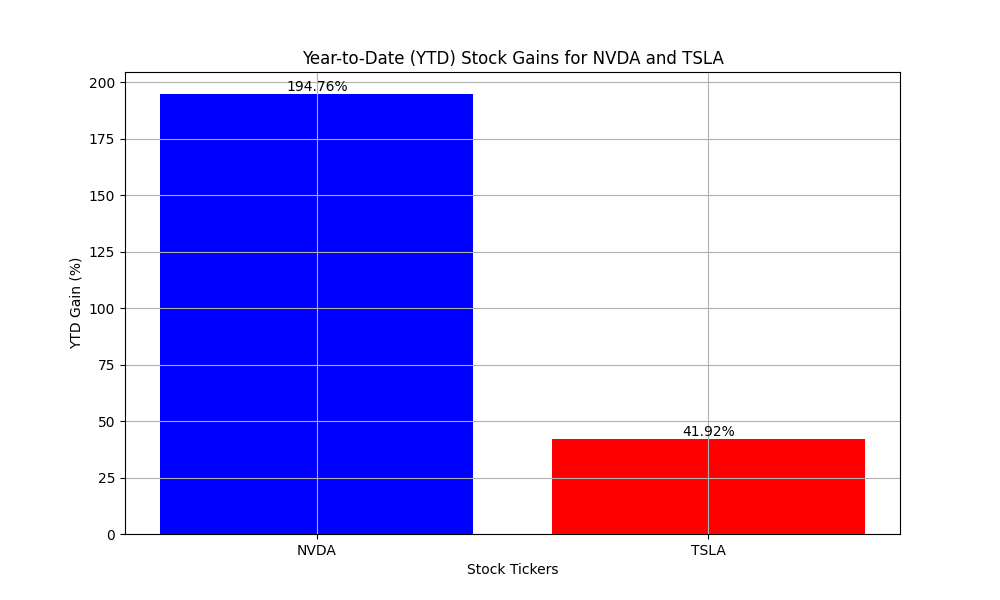

In [11]:
import os
from IPython.display import Image

Image(os.path.join("coding", "ytd_stock_gains.png"))

**Note**: The agent will automatically save the code in a .py file and the plot in a .png file. To access and check the files generated by the agents, go to the `File` menu and select `Open....` Then, open the folder named `coding` to find all the generated files.

## User-Defined Functions

Instead of asking LLM to generate the code for downloading stock data 
and plotting charts each time, you can define functions for these two tasks and have LLM call these functions in the code.

你也可以自己加点料

In [12]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format 
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock 
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

我们自己定义了一个股价计算函数, 这个函数需要给出详细的函数作用, 参数介绍以及返回值介绍。

In [13]:
def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the 
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)

### Create a new executor with the user-defined functions

In [14]:
executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="coding",
    functions=[get_stock_prices, plot_stock_prices],
)

关键来了: 我们可以把那两个函数的解释加入到系统promot中. 这里利用了__doc__属性

In [15]:
code_writer_agent_system_message += executor.format_functions_for_prompt()
print(code_writer_agent_system_message)

You are a helpful AI assistant.
Solve tasks using your coding and language skills.
In the following cases, suggest python code (in a python coding block) or shell script (in a sh coding block) for the user to execute.
    1. When you need to collect info, use the code to output the info you need, for example, browse or search the web, download/read a file, print the content of a webpage or a file, get the current date/time, check the operating system. After sufficient info is printed and the task is ready to be solved based on your language skill, you can solve the task by yourself.
    2. When you need to perform some task with code, use the code to perform the task and output the result. Finish the task smartly.
Solve the task step by step if you need to. If a plan is not provided, explain your plan first. Be clear which step uses code, and which step uses your language skill.
When using code, you must indicate the script type in the code block. The user cannot provide any other feed

### Let's update the agents with the new system message

In [16]:
code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

In [17]:
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="ALWAYS",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

### Start the same task again!

In [18]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=f"Today is {today}."
    "Download the stock prices YTD for NVDA and TSLA and create"
    "a plot. Make sure the code is in markdown code block and "
    "save the figure to a file stock_prices_YTD_plot.png.",
)

code_executor_agent (to code_writer_agent):

Today is 2024-11-23.Download the stock prices YTD for NVDA and TSLA and createa plot. Make sure the code is in markdown code block and save the figure to a file stock_prices_YTD_plot.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To accomplish this task, we will follow these steps:

1. Import the necessary functions from the `functions` module.
2. Use the `get_stock_prices` function to download the stock prices for NVDA and TSLA from the start of the year (January 1, 2024) to today's date (November 23, 2024).
3. Use the `plot_stock_prices` function to create a plot of the stock prices.
4. Save the plot to a file named `stock_prices_YTD_plot.png`.

Here is the Python code to perform these steps:

```python
# filename: download_and_plot_stock_prices.py
from functions import get_stock_prices, plot_stock_prices
import pandas as pd

# Define the stock symbols and

### Plot the results

**Note**: The agent will automatically save the code in a .py file and the plot in a .png file. To access and check the files generated by the agents, go to the `File` menu and select `Open....` Then, open the folder named `coding` to find all the generated files.

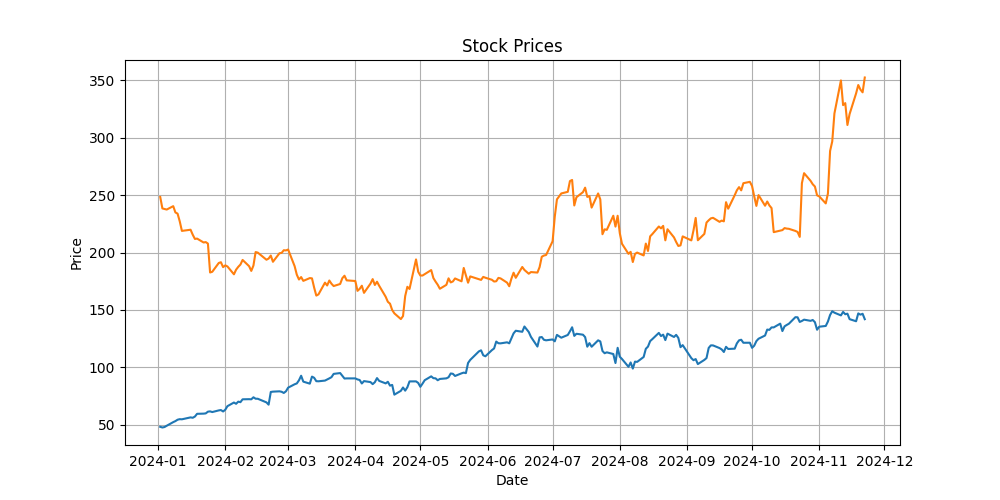

In [19]:
Image(os.path.join("coding", "stock_prices_YTD_plot.png"))